**WORK FLOW:**


SECTIONS FOR PRESENTATION
        
        IMPORTS
        MY DEFINED FUNCTIONS
        COLUMN DESCRIPTIONS
        MODEL PREP
        BEST MODEL
        2020 PREDICTIONS
        
 

 
 
 

SECTIONS OF ANALYSIS WHAT TO USE FOR PRESENTATION
        
        INDEPTH EDA
        OTHER MODELS NOT USED

**IMPORTS**

In [1]:

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from statsmodels.stats.diagnostic import het_breuschpagan
from sklearn import tree, ensemble
import pandas as pd
import numpy as np
from sklearn.svm import SVR, SVC
from scipy import stats
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_regression, f_classif
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import math
from sklearn.metrics import mean_absolute_error,confusion_matrix, classification_report
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.eval_measures import mse, rmse
import warnings
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
%matplotlib inline

**MY DEFINED FUNCTIONS**

In [2]:
def print_vif(x):
    """Utility for checking multicollinearity assumption
    
    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=x.columns))
    print("-------------------------------\n")
    
def eval_preds(y_true, y_pred):
    error = y_true - y_pred

    rmse = np.sqrt((error ** 2).mean())
    mae = error.abs().mean()
    mape = (error / y_true).abs().mean()

    print(f"rmse {rmse:.2f}")
    print(f"mae {mae:.2f}")
    print(f"mape {mape:.2f}")

    line_pts = [y_true.min(), y_true.max()]
    plt.scatter(y_true, y_pred)
    plt.plot(line_pts, line_pts, c="red", ls="--", alpha=0.5)
    plt.xlabel("Actual")
    plt.ylabel("Fit")
    plt.show()
    
def one_hot_encode(X, encode_cols, index=None):
    other_cols = [c for c in X.columns if c not in encode_cols]

    ct = ColumnTransformer(
        #   Format
        #   [("name of step", what_to_do(), [what columns to do it to])]
        [("one hot encode", OneHotEncoder(drop="first", sparse=False), encode_cols)],
        remainder="passthrough",
    )

    ct.fit(X)

    # This is not the flexible and definitely not the most
    # readable way to get column names, a function would be better
    encoded_names = ct.transformers_[0][1].get_feature_names()
    encoded_names = list(encoded_names)

    X_encoded = ct.transform(X)
    X_encoded = pd.DataFrame(X_encoded, columns=encoded_names + other_cols, index=index)

    return X_encoded

**Column descriptions** 'G', 'W', 'BARTHAG', 'TOR', 'ORB', 'DRB', 'FTR', '2P_O', '2P_D',
       '3P_D'

RK: The ranking of the team at the end of the regular season according to barttorvik

TEAM:The Division I college basketball school

CONF:The Athletic Conference in which the school participates in (A10 = Atlantic 10, ACC = Atlantic Coast Conference, AE = America East, Amer = American, ASun = ASUN, B10 = Big Ten, B12 = Big 12, BE = Big East, BSky = Big Sky, BSth = Big South, BW = Big West, CAA = Colonial Athletic Association, CUSA = Conference USA, Horz = Horizon League, Ivy = Ivy League, MAAC = Metro Atlantic Athletic Conference, MAC = Mid-American Conference, MEAC = Mid-Eastern Athletic Conference, MVC = Missouri Valley Conference, MWC = Mountain West, NEC = Northeast Conference, OVC = Ohio Valley Conference, P12 = Pac-12, Pat = Patriot League, SB = Sun Belt, SC = Southern Conference, SEC = South Eastern Conference, Slnd = Southland Conference, Sum = Summit League, SWAC = Southwestern Athletic Conference, WAC = Western Athletic Conference, WCC = West Coast Conference)

GNumber: of games played

WNumber: of games won

ADJOE: Adjusted Offensive Efficiency (An estimate of the offensive efficiency (points scored per 100 possessions) a team would have against the average Division I defense)

ADJDE: Adjusted Defensive Efficiency (An estimate of the defensive efficiency (points allowed per 100 possessions) a team would have against the average Division I offense)

BARTHAG: Power Rating (Chance of beating an average Division I team)

EFG_O: Effective Field Goal Percentage Shot

EFG_D: Effective Field Goal Percentage Allowed

TOR: Turnover Percentage Allowed (Turnover Rate)

TORD: Turnover Percentage Committed (Steal Rate)

ORB: Offensive Rebound Percentage

DRB: Defensive Rebound Percentage

FTR: Free Throw Rate (How often the given team shoots Free Throws)

FTRD: Free Throw Rate Allowed

2P_O: Two-Point Shooting Percentage

2P_D: Two-Point Shooting Percentage Allowed

3P_O: Three-Point Shooting Percentage

3P_D: Three-Point Shooting Percentage Allowed

ADJ_T: Adjusted Tempo (An estimate of the tempo (possessions per 40 minutes) a team would have against the team that wants to play at an average Division I tempo)

WAB: Wins Above Bubble (The bubble refers to the cut off between making the NCAA March Madness Tournament and not making it)

POSTSEASON: Round where the given team was eliminated or where their season ended (R68 = First Four, R64 = Round of 64, R32 = Round of 32, S16 = Sweet Sixteen, E8 = Elite Eight, F4 = Final Four, 2ND = Runner-up, Champion = Winner of the NCAA March Madness Tournament for that given year)

SEED: Seed in the NCAA March Madness Tournament YEAR: Season

In [3]:
cbb = pd.read_csv('cbb.csv')

-------------------------------------------------------------------------------------------------------------------------------


**MODEL PREP** (for more  indepth reasons of why i maniplulated the data the way i did see EDA section)

In [4]:
#i noticed a huge difference in number of games and did some double checking the 'G' values 24-26 are missing games. 
#I also noticed the 'CONF' value Slnd has a lot off errrors. CONF == Ind only has one value.
#so i am droppnig rows with (conf == Slnd or Ind) and rows G <=26
cbb = cbb.loc[cbb['G'] >= 27]
cbb = cbb.loc[cbb['CONF'] != 'Slnd']
cbb = cbb.loc[cbb['CONF'] != 'Ind']


In [5]:
# trying to predict who would make NCAA basketball tourn using'SEED' as prediction 'POSTSEASON' and 'WAB' are cheat 
#columns so dropping them
cbb_seed_con = cbb.copy()
cbb_seed_con = cbb_seed_con.drop(columns=['POSTSEASON', 'WAB'])

In [6]:
#change nan values in 'SEED'(teams that didnt make it to tourn had nan value in this column) to value of 17
cbb_seed_con.loc[cbb_seed_con['SEED'].isna(), 'SEED'] = 17

In [7]:
#after looking at correlation  and vif decided to drop the following columns  #'ADJOE', 'ADJDE',
cbb_seed_con =cbb_seed_con.drop(columns=[ 'CONF','EFG_O', 'EFG_D', 'ADJ_T', '3P_O', 'FTRD','TORD','ADJOE', 'ADJDE'])
cbb_seed_con =cbb_seed_con.drop(columns=['TEAM', 'YEAR'])
cbb_seed_con.head()
                  

,G,W,BARTHAG,TOR,ORB,DRB,FTR,2P_O,2P_D,3P_D,SEED
0,40,33,0.9531,15.4,40.7,30.0,32.3,53.9,44.6,36.2,1.0
1,40,36,0.9758,12.4,32.1,23.7,36.2,54.8,44.7,37.5,1.0
2,40,33,0.9375,14.0,25.5,24.9,30.7,54.7,46.8,33.2,3.0
3,38,31,0.9696,17.7,27.4,28.7,32.9,52.8,41.9,29.7,3.0
4,39,37,0.9728,16.2,30.0,26.2,39.0,56.3,40.0,29.0,1.0


**MODEL USED FOR 'SEED' PREDICTION:** ols

In [8]:
#define X and Y
y = cbb_seed_con['SEED']
X = cbb_seed_con.drop(columns=['SEED'])
#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 85, stratify=y)

In [9]:
X_train.columns

Index(['G', 'W', 'BARTHAG', 'TOR', 'ORB', 'DRB', 'FTR', '2P_O', '2P_D',
       '3P_D'],
      dtype='object')

In [10]:
#print_vif(X_train.drop(columns=['ADJOE', 'ADJDE','EFG_O', 'EFG_D']))
print_vif(X_train)

VIF results
-------------------------------
const      1713.184387
G             2.379812
W             6.013072
BARTHAG       4.354789
TOR           1.860429
ORB           1.566570
DRB           1.249509
FTR           1.142708
2P_O          2.218176
2P_D          1.951186
3P_D          1.513373
dtype: float64
-------------------------------



In [11]:
# add constant and fit model
X_train = sm.add_constant(X_train)
results = sm.OLS(y_train, X_train).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   SEED   R-squared:                       0.452
Model:                            OLS   Adj. R-squared:                  0.448
Method:                 Least Squares   F-statistic:                     109.5
Date:                Sat, 25 Apr 2020   Prob (F-statistic):          1.03e-165
Time:                        20:01:42   Log-Likelihood:                -3329.6
No. Observations:                1341   AIC:                             6681.
Df Residuals:                    1330   BIC:                             6738.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         33.7583      3.289     10.264      0.0

In [12]:
#test model
X_test = sm.add_constant(X_test)
y_preds = results.predict(X_test)

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

Mean absolute error of the prediction is: 2.1570777543670734
Mean squared error of the prediction is: 8.24195840752645
Root mean squared error of the prediction is: 2.870881120409978
Mean absolute percentage error of the prediction is: 32.44153666923067


rmse 2.87
mae 2.16
mape 0.32


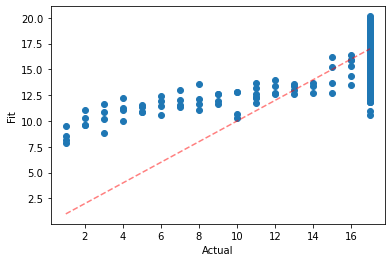

In [29]:
eval_preds(y_test, y_preds)

In [13]:
# tested model for over all predicion but seeds 1-16 all get into tourn so checking ability to predict
# which teams will make it to the tourn
ols_df = X_test.copy()
ols_df['predictions'] = y_preds
ols_df['actuals'] = y_test
ols_df.loc[(ols_df['actuals'] > 16), 'predictions'] = 17
ols_df['errors'] = ols_df['predictions'] -ols_df['actuals']
ols_df['abs_err'] = ols_df['errors'].abs()
ols_df['actual_label'] = ols_df['actuals'] <= 16
ols_df['pred_label'] = ols_df['predictions'] <= 16

In [14]:
ols_df.sort_values('abs_err', ascending =False)

,const,G,W,BARTHAG,TOR,ORB,DRB,FTR,2P_O,2P_D,3P_D,predictions,actuals,errors,abs_err,actual_label,pred_label
1465,1.0,34,25,0.9469,16.0,36.7,28.5,34.0,50.5,44.8,31.6,11.059533,2.0,9.059533,9.059533,True,True
1577,1.0,34,25,0.9103,15.8,28.3,29.6,36.5,54.3,45.2,34.7,11.683683,3.0,8.683683,8.683683,True,True
24,1.0,37,30,0.9163,16.1,34.1,30.5,40.3,52.6,46.1,36.2,9.485654,1.0,8.485654,8.485654,True,True
1463,1.0,37,28,0.9436,16.3,31.7,29.8,39.3,53.5,48.9,29.3,10.319046,2.0,8.319046,8.319046,True,True
1494,1.0,33,22,0.8945,19.2,34.3,31.0,43.9,50.5,43.1,36.2,12.190805,4.0,8.190805,8.190805,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
792,1.0,28,7,0.0632,18.5,26.3,34.7,37.6,44.7,52.5,36.1,17.000000,17.0,0.000000,0.000000,False,False
75,1.0,31,9,0.2223,18.5,18.8,32.8,26.9,52.1,52.1,35.1,17.000000,17.0,0.000000,0.000000,False,False
66,1.0,35,20,0.5886,19.3,32.7,26.4,36.6,45.6,48.9,35.4,17.000000,17.0,0.000000,0.000000,False,False
856,1.0,32,20,0.5446,18.7,25.9,29.0,32.4,51.5,50.9,33.3,17.000000,17.0,0.000000,0.000000,False,False


In [15]:
ols_filter = ols_df['actual_label'] == 1
actual_ols = ols_df.loc[ ols_filter]
actual_ols['abs_err'].mean()

3.766374312934122

In [16]:
cm = confusion_matrix(ols_df['actual_label'],ols_df['pred_label'])
cm_df = pd.DataFrame(
    cm, 
    index=['actual_0', 'actual_1'], 
    columns=['pred_0', 'pred_1']
)

display(cm_df)
print('\n')
print(classification_report(ols_df['actual_label'],ols_df['pred_label']))

,pred_0,pred_1
actual_0,269,0
actual_1,2,65




              precision    recall  f1-score   support

       False       0.99      1.00      1.00       269
        True       1.00      0.97      0.98        67

    accuracy                           0.99       336
   macro avg       1.00      0.99      0.99       336
weighted avg       0.99      0.99      0.99       336



In [17]:
ols_df.loc[(ols_df['actual_label'] == True) & (ols_df['pred_label'] == False)]

,const,G,W,BARTHAG,TOR,ORB,DRB,FTR,2P_O,2P_D,3P_D,predictions,actuals,errors,abs_err,actual_label,pred_label
1705,1.0,32,19,0.1522,20.8,32.9,29.7,30.3,51.3,48.1,32.8,16.356334,16.0,0.356334,0.356334,True,False
1613,1.0,30,20,0.4760,20.7,26.0,28.9,45.6,52.0,45.0,36.4,16.196956,15.0,1.196956,1.196956,True,False


## great model. only made 2 wrong predictions. 2 teams which we predicted wouldnt get in actually got in

**2020 PREDICTIONS:** (what could have been)

In [18]:
cbb20 = pd.read_csv('cbb20.csv')
cbb20 = cbb20.loc[cbb20['G'] >= 27]
cbb20 = cbb20.loc[cbb20['CONF'] != 'Slnd']
cbb20.head()

,RK,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,...,ORB,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB
0,1,Kansas,B12,30,28,116.1,87.7,0.9616,53.7,43.7,...,32.6,26.4,35.8,23.2,54.9,42.4,34.1,30.5,67.4,10.8
1,2,Baylor,B12,30,26,114.5,88.4,0.9513,49.4,45.2,...,35.8,29.8,30.8,30.8,47.5,44.4,35.1,31.1,66.2,8.5
2,3,Gonzaga,WCC,33,31,121.3,94.3,0.9472,57.5,47.6,...,33.6,22.7,38.8,21.8,57.4,47.4,38.6,32.0,72.0,7.7
3,4,Dayton,A10,31,29,119.5,93.4,0.9445,59.7,46.6,...,26.4,26.6,33.9,30.9,62.3,45.1,37.1,33.0,67.5,6.8
4,5,Michigan St.,B10,31,22,114.8,91.3,0.9326,52.6,43.3,...,32.8,26.0,30.8,29.3,52.9,43.4,34.8,28.7,69.3,5.2


In [19]:
#read in 2020 and prep it the same as X_test
cbb20_p = cbb20.copy()


cbb20_p  = cbb20_p[['G', 'W', 'BARTHAG', 'TOR', 'ORB', 'DRB', 'FTR', '2P_O', '2P_D',
       '3P_D']]
cbb20_p = sm.add_constant(cbb20_p)

In [20]:
y_preds_20 = results.predict(cbb20_p)
cbb20['pred'] = y_preds_20

In [25]:
#taking the top 64 predictions
cbb_tourn = cbb20.sort_values(['pred']).head(64)

In [26]:
cbb_tourn.head(10)

,RK,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,...,DRB,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,pred
2,3,Gonzaga,WCC,33,31,121.3,94.3,0.9472,57.5,47.6,...,22.7,38.8,21.8,57.4,47.4,38.6,32.0,72.0,7.7,11.477934
1,2,Baylor,B12,30,26,114.5,88.4,0.9513,49.4,45.2,...,29.8,30.8,30.8,47.5,44.4,35.1,31.1,66.2,8.5,11.681360
19,20,Florida St.,ACC,31,26,111.2,92.5,0.8921,51.9,47.0,...,30.2,30.1,34.4,51.5,46.6,35.1,31.7,69.9,6.9,11.840643
9,10,San Diego St.,MWC,31,30,113.8,92.8,0.9119,54.6,45.2,...,25.4,28.3,30.6,53.0,45.3,37.9,30.1,64.7,6.7,11.931222
17,18,Oregon,P12,31,24,117.5,97.4,0.8968,54.3,47.3,...,31.1,28.9,29.5,51.4,46.2,39.6,32.6,65.2,4.7,12.018856
5,6,Duke,ACC,31,25,115.3,91.9,0.9310,52.6,45.7,...,28.0,35.6,30.9,52.5,46.0,35.2,29.9,71.7,5.1,12.399747
3,4,Dayton,A10,31,29,119.5,93.4,0.9445,59.7,46.6,...,26.6,33.9,30.9,62.3,45.1,37.1,33.0,67.5,6.8,12.422923
0,1,Kansas,B12,30,28,116.1,87.7,0.9616,53.7,43.7,...,26.4,35.8,23.2,54.9,42.4,34.1,30.5,67.4,10.8,12.436607
40,41,Saint Mary's,WCC,33,25,114.0,98.8,0.8385,54.2,50.8,...,23.6,30.8,28.0,51.9,50.7,38.8,34.0,63.8,2.8,12.626998
11,12,Houston,Amer,31,23,112.1,92.2,0.9041,48.0,43.9,...,25.3,32.9,41.6,46.6,44.5,33.7,28.6,65.7,2.7,12.634319


In [23]:
cbb_tourn.TEAM.unique()

array(['Gonzaga', 'Baylor', 'Florida St.', 'San Diego St.', 'Oregon',
       'Duke', 'Dayton', 'Kansas', "Saint Mary's", 'Houston', 'Hofstra',
       'East Tennessee St.', 'Creighton', 'Louisville', 'Villanova',
       'San Francisco', 'Kentucky', 'Maryland', 'Utah St.',
       'West Virginia', 'North Carolina St.', 'Auburn', 'Penn St.',
       'Michigan St.', 'Belmont', 'Notre Dame', 'LSU', 'Arizona', 'Iowa',
       'UNC Greensboro', 'Butler', 'Wichita St.', 'Wisconsin',
       'Providence', "St. John's", 'Bradley', 'BYU', 'Texas', 'Illinois',
       'Ohio St.', 'Liberty', 'Colgate', 'Xavier', 'Purdue', 'Syracuse',
       'Colorado', 'Richmond', 'Connecticut', 'Seton Hall', 'USC',
       'Vermont', 'Mississippi St.', 'Indiana', 'Pittsburgh', 'Florida',
       'Arizona St.', 'Rutgers', 'Virginia', 'Saint Louis',
       'Northern Iowa', 'Oklahoma St.', 'Michigan', 'TCU', 'Texas Tech'],
      dtype=object)

**INDEPTH EDA**

In [24]:
cbb = pd.read_csv('cbb.csv')


In [25]:
#checking description max, min, ect to see if anything justs out as an error. 
#also checking nans only obvious nul values are in in 'POSTSEASON' and 'SEED' 
#which makes sense if they didnt make the tournament there wouldnt be any values
cbb.describe()

,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,TORD,ORB,...,FTR,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,SEED,YEAR
count,1757.000000,1757.000000,1757.000000,1757.000000,1757.000000,1757.000000,1757.000000,1757.000000,1757.000000,1757.000000,...,1757.000000,1757.000000,1757.000000,1757.000000,1757.000000,1757.000000,1757.000000,1757.000000,340.000000,1757.000000
mean,31.523051,16.513375,103.542402,103.542459,0.493398,50.120489,50.312806,18.591804,18.521286,29.277120,...,35.097894,35.373307,49.135970,49.298065,34.563517,34.744792,68.422254,-7.837109,8.791176,2017.002277
std,2.602819,6.545571,7.304975,6.472676,0.255291,3.130430,2.859604,1.991637,2.108968,4.101782,...,4.884599,5.900935,3.422136,3.288265,2.742323,2.369727,3.258920,6.988694,4.674090,1.415419
min,24.000000,0.000000,76.700000,84.000000,0.007700,39.400000,39.600000,12.400000,10.200000,15.000000,...,21.600000,21.800000,37.700000,37.700000,25.200000,27.100000,57.200000,-25.200000,1.000000,2015.000000
25%,30.000000,12.000000,98.600000,98.900000,0.283700,48.100000,48.400000,17.200000,17.100000,26.600000,...,31.700000,31.200000,46.900000,47.100000,32.600000,33.100000,66.400000,-13.000000,5.000000,2016.000000
50%,31.000000,16.000000,103.100000,103.800000,0.474000,50.000000,50.300000,18.500000,18.500000,29.400000,...,34.900000,34.900000,49.000000,49.300000,34.600000,34.700000,68.500000,-8.400000,9.000000,2017.000000
75%,33.000000,21.000000,108.100000,108.000000,0.710600,52.100000,52.300000,19.800000,19.900000,31.900000,...,38.300000,39.200000,51.400000,51.500000,36.400000,36.300000,70.400000,-3.100000,13.000000,2018.000000
max,40.000000,38.000000,129.100000,124.000000,0.984200,59.800000,59.500000,26.100000,28.000000,42.100000,...,51.000000,58.500000,62.600000,61.200000,44.100000,43.100000,83.400000,13.100000,16.000000,2019.000000


In [26]:
cbb.isna().mean()

TEAM          0.000000
CONF          0.000000
G             0.000000
W             0.000000
ADJOE         0.000000
ADJDE         0.000000
BARTHAG       0.000000
EFG_O         0.000000
EFG_D         0.000000
TOR           0.000000
TORD          0.000000
ORB           0.000000
DRB           0.000000
FTR           0.000000
FTRD          0.000000
2P_O          0.000000
2P_D          0.000000
3P_O          0.000000
3P_D          0.000000
ADJ_T         0.000000
WAB           0.000000
POSTSEASON    0.806488
SEED          0.806488
YEAR          0.000000
dtype: float64

In [27]:
#the min number of games jumped out at me in decribe. seemed low. 
#i doublechecked at values below 27. everything below 26 had games missing from data set
# 'G' = 27  most seemed right but 'conf'= Slnd had several mistakes so i dropped that all Slnd
#conf value counts lead me to believe Ind was a mistake too so i removed it
cbb.loc[cbb['G'] == 24]

,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,...,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR
1238,Houston Baptist,Slnd,24,8,98.6,115.7,0.1377,47.4,52.8,21.4,...,43.7,47.5,51.0,31.5,37.9,66.7,-12.0,NaN,NaN,2015
1256,Northwestern St.,Slnd,24,5,100.8,118.2,0.1378,50.2,55.1,19.5,...,36.1,49.5,54.8,34.3,37.1,74.2,-14.4,NaN,NaN,2016
1275,Incarnate Word,Slnd,24,7,94.5,113.9,0.1047,47.6,52.5,23.2,...,33.8,45.4,50.6,34.6,37.6,70.6,-16.5,NaN,NaN,2018
1311,Western Illinois,Sum,24,7,99.5,106.2,0.3205,49.3,50.1,18.2,...,42.4,46.0,46.4,37.8,39.1,68.6,-11.4,NaN,NaN,2016
1326,Western Illinois,Sum,24,12,96.4,106.1,0.2487,49.9,51.2,18.6,...,29.3,48.6,48.9,34.9,36.6,69.2,-11.0,NaN,NaN,2018


In [28]:
cbb.loc[cbb['G'] == 25]

,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,...,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR
1239,Incarnate Word,Slnd,25,14,104.1,111.9,0.3028,52.0,51.4,15.7,...,39.6,51.8,50.6,35.0,35.5,67.7,-6.0,NaN,NaN,2015
1251,Incarnate Word,Slnd,25,14,99.6,110.7,0.2274,49.9,52.9,17.8,...,38.1,44.7,52.4,38.9,35.9,68.3,-6.3,NaN,NaN,2016
1260,Abilene Christian,Slnd,25,13,97.5,107.5,0.2450,52.5,52.8,21.0,...,44.3,50.7,52.1,37.1,36.1,67.1,-12.5,NaN,NaN,2017
1263,Incarnate Word,Slnd,25,12,100.7,113.7,0.1993,51.4,51.5,18.6,...,38.9,48.2,51.8,37.8,33.7,73.1,-13.2,NaN,NaN,2017
1267,Northwestern St.,Slnd,25,13,100.0,112.5,0.2056,50.1,53.9,20.8,...,39.4,47.9,52.5,36.3,37.8,72.3,-12.0,NaN,NaN,2017
1277,McNeese St.,Slnd,25,12,99.2,111.0,0.2155,48.8,49.8,19.0,...,31.5,47.3,48.4,34.6,35.0,71.0,-12.6,NaN,NaN,2018
1280,Northwestern St.,Slnd,25,4,88.2,109.9,0.0743,44.3,54.1,24.7,...,40.1,44.9,53.1,28.3,37.2,70.5,-18.1,NaN,NaN,2018


In [29]:
cbb.loc[cbb['G'] == 26]

,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,...,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR
375,North Dakota,BSky,26,12,97.4,104.6,0.3050,51.3,52.5,17.9,...,30.0,49.6,52.2,36.0,35.3,71.1,-12.8,NaN,NaN,2019
640,Columbia,Ivy,26,11,100.0,105.8,0.3433,49.7,52.0,18.4,...,34.8,47.1,50.4,36.1,36.1,70.3,-11.1,NaN,NaN,2017
643,Harvard,Ivy,26,18,105.7,101.4,0.6165,52.3,47.4,19.8,...,39.5,51.2,47.8,35.9,31.2,68.1,-5.1,NaN,NaN,2017
646,Brown,Ivy,26,11,101.0,109.2,0.2899,48.5,54.4,18.4,...,40.0,48.6,53.9,32.1,37.0,72.7,-11.6,NaN,NaN,2018
647,Columbia,Ivy,26,8,107.9,113.0,0.3698,52.4,54.2,17.8,...,32.0,49.9,51.6,37.2,38.4,71.1,-13.6,NaN,NaN,2018
649,Dartmouth,Ivy,26,7,96.9,109.5,0.1968,51.4,54.4,20.0,...,25.6,49.7,55.5,36.0,35.1,67.9,-15.4,NaN,NaN,2018
654,Columbia,Ivy,26,10,102.0,105.6,0.4033,51.5,52.1,18.0,...,38.1,50.6,51.0,35.4,35.8,68.9,-12.5,NaN,NaN,2019
659,Princeton,Ivy,26,16,97.9,98.5,0.4819,47.0,49.7,17.8,...,28.7,48.1,50.3,30.3,32.5,68.8,-5.6,NaN,NaN,2019
964,SIU Edwardsville,OVC,26,10,95.3,103.1,0.2875,48.7,49.3,20.3,...,37.0,45.3,46.9,36.9,36.1,66.6,-11.8,NaN,NaN,2015
1240,Lamar,Slnd,26,11,97.4,107.6,0.2414,49.7,52.8,23.4,...,46.0,50.7,50.8,31.9,37.6,66.5,-9.9,NaN,NaN,2015


In [30]:
cbb.loc[cbb['G'] == 27]

,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,...,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR
169,New Hampshire,AE,27,5,83.7,106.1,0.0613,44.0,51.5,18.4,...,38.0,39.4,52.1,32.6,33.6,67.1,-20.2,NaN,NaN,2019
334,Portland St.,BSky,27,13,100.9,107.9,0.3144,48.7,52.7,16.4,...,31.4,45.5,50.2,37.3,38.5,66.2,-9.9,NaN,NaN,2015
355,Northern Colorado,BSky,27,11,97.2,105.4,0.2841,51.0,52.2,20.3,...,34.5,50.6,52.0,34.3,35.0,70.1,-12.6,NaN,NaN,2017
392,Campbell,BSth,27,9,99.6,113.1,0.1871,49.5,53.5,16.4,...,39.3,50.7,52.1,31.7,37.8,69.2,-15.1,NaN,NaN,2016
393,Charleston Southern,BSth,27,6,97.8,110.5,0.1959,50.0,54.0,17.9,...,37.7,49.4,52.6,33.8,37.4,69.2,-15.5,NaN,NaN,2016
414,High Point,BSth,27,14,98.5,106.5,0.2907,49.3,50.1,19.1,...,40.1,47.6,48.8,35.9,34.8,66.8,-12.4,NaN,NaN,2018
429,Winthrop,BSth,27,18,104.8,107.0,0.4404,54.2,51.3,20.2,...,30.3,53.3,51.6,36.7,33.8,74.3,-6.5,NaN,NaN,2019
430,Cal Poly,BW,27,11,101.5,100.0,0.5427,44.1,49.3,14.8,...,31.3,42.5,47.3,31.6,35.6,59.2,-9.0,NaN,NaN,2015
452,UC Riverside,BW,27,8,93.1,104.7,0.2053,45.7,49.8,19.9,...,34.1,44.9,47.9,31.6,35.1,69.0,-16.3,NaN,NaN,2017
453,UC Santa Barbara,BW,27,6,92.0,106.2,0.1597,42.1,52.5,18.3,...,32.3,41.7,53.2,28.5,34.4,66.1,-16.2,NaN,NaN,2017


In [31]:
cbb.loc[cbb['CONF'] == 'Slnd'].head()

,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,...,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR
1236,Abilene Christian,Slnd,28,7,90.6,111.3,0.0854,47.3,55.3,19.8,...,44.7,42.0,55.2,37.8,37.0,64.0,-16.8,NaN,NaN,2015
1237,Central Arkansas,Slnd,29,2,89.1,116.3,0.0447,48.8,55.0,25.6,...,42.5,46.5,54.4,35.3,37.6,69.9,-23.0,NaN,NaN,2015
1238,Houston Baptist,Slnd,24,8,98.6,115.7,0.1377,47.4,52.8,21.4,...,43.7,47.5,51.0,31.5,37.9,66.7,-12.0,NaN,NaN,2015
1239,Incarnate Word,Slnd,25,14,104.1,111.9,0.3028,52.0,51.4,15.7,...,39.6,51.8,50.6,35.0,35.5,67.7,-6.0,NaN,NaN,2015
1240,Lamar,Slnd,26,11,97.4,107.6,0.2414,49.7,52.8,23.4,...,46.0,50.7,50.8,31.9,37.6,66.5,-9.9,NaN,NaN,2015


In [32]:
#these value look good when double checked
cbb.loc[cbb['CONF'] == 'Sum'].head()

,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,...,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR
1296,Denver,Sum,30,12,103.5,107.5,0.3943,56.2,52.9,19.1,...,51.2,55.5,51.7,38.0,37.1,57.9,-12.5,NaN,NaN,2015
1297,IPFW,Sum,28,13,104.5,107.5,0.4180,53.3,51.3,18.7,...,27.7,52.6,49.9,36.3,36.0,65.0,-9.2,NaN,NaN,2015
1298,IUPUI,Sum,31,10,92.4,101.2,0.2580,46.5,51.3,23.6,...,41.8,47.3,48.5,29.6,38.3,64.1,-14.5,NaN,NaN,2015
1299,Nebraska Omaha,Sum,28,11,100.3,108.0,0.2994,49.3,53.3,18.3,...,38.9,49.2,51.7,33.1,37.6,74.2,-12.8,NaN,NaN,2015
1300,Oral Roberts,Sum,32,17,104.1,107.5,0.4106,48.1,51.0,17.6,...,37.8,45.6,48.8,35.8,37.5,65.8,-8.4,NaN,NaN,2015


In [33]:
cbb['CONF'].value_counts

<bound method IndexOpsMixin.value_counts of 0       ACC
1       B10
2       B10
3       B12
4       WCC
       ... 
1752    SEC
1753    SEC
1754    SEC
1755    WCC
1756    WCC
Name: CONF, Length: 1757, dtype: object>

In [34]:
cbb = cbb.loc[cbb['G'] >= 27]
cbb = cbb.loc[cbb['CONF'] != 'Slnd']
cbb = cbb.loc[cbb['CONF'] != 'Ind']
cbb_seed_con = cbb.copy()


In [35]:
cbb_seed_con['SEED']

0        1.0
1        1.0
2        3.0
3        3.0
4        1.0
        ... 
1752     7.0
1753     3.0
1754     2.0
1755    11.0
1756     4.0
Name: SEED, Length: 1677, dtype: float64

In [36]:
cbb_seed_con.loc[cbb_seed_con['SEED'].isna(), 'SEED'] = 17

In [37]:
#these are cheater columns for prediction so dropped them
cbb_seed_con = cbb_seed_con.drop(columns=['POSTSEASON', 'WAB'])

In [38]:
#orriginally created this bout found teams w high win perc but low numb of games really skewd my data 
#teams who play more games are more likely to get in to tourn then teams w fewer games played
#cbb['W_perc'] = (cbb['W']/cbb['G'])

In [39]:
cbb_seed_con = cbb_seed_con.drop(columns=['TEAM'])

In [40]:
cbb_seed_con.corr()['SEED'].abs().sort_values(ascending=False)

SEED       1.000000
ADJOE      0.633276
BARTHAG    0.619595
W          0.616626
G          0.574511
ADJDE      0.555917
EFG_D      0.409782
2P_D       0.382702
EFG_O      0.365924
2P_O       0.331855
TOR        0.317688
3P_O       0.287535
3P_D       0.278146
ORB        0.268115
FTRD       0.238300
DRB        0.142958
TORD       0.062076
FTR        0.058703
ADJ_T      0.043401
YEAR       0.000182
Name: SEED, dtype: float64

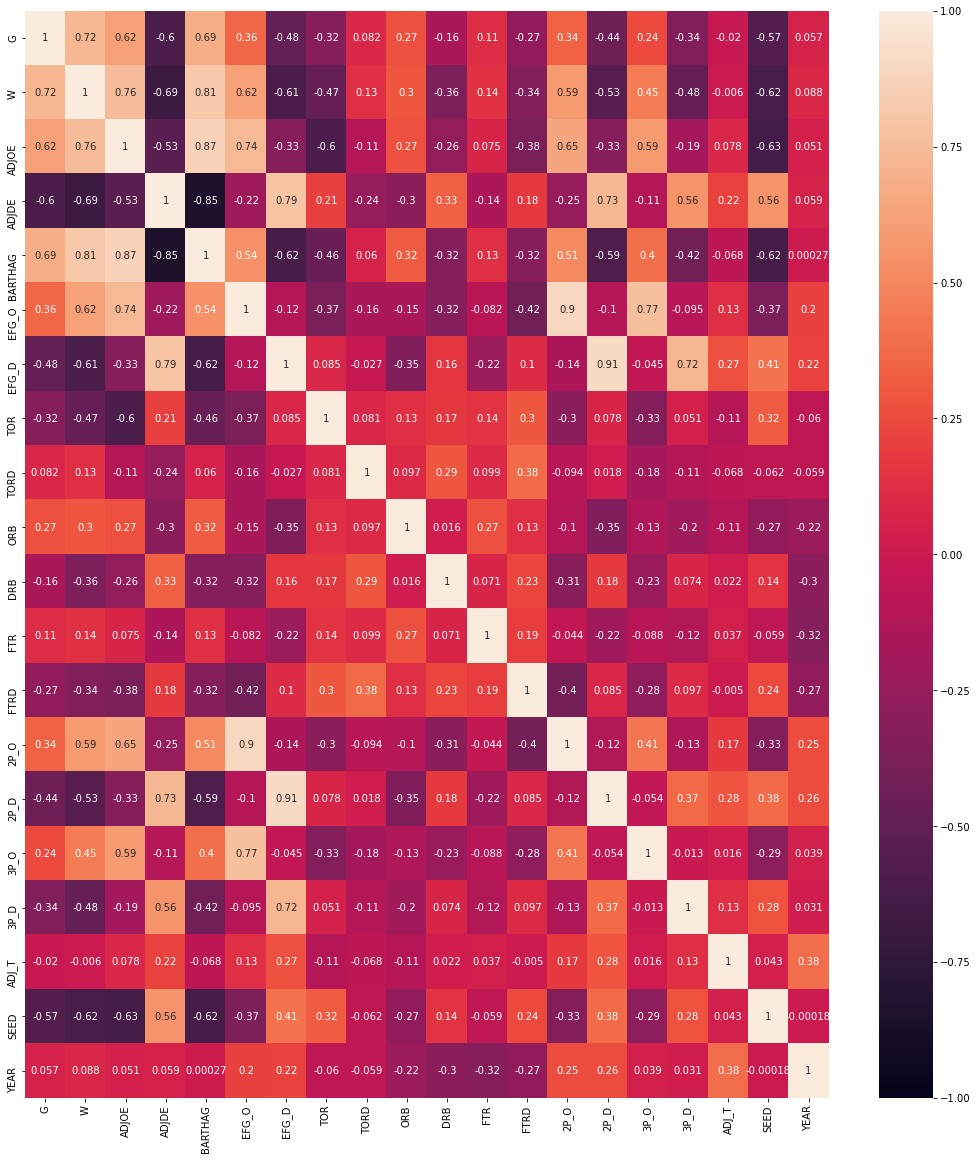

In [41]:
plt.figure(figsize=(18,20))
sns.heatmap(cbb_seed_con.corr(), vmin=-1, vmax=1, annot=True)

In [42]:
cbb_seed_con_tall = cbb_seed_con.melt(id_vars='SEED')

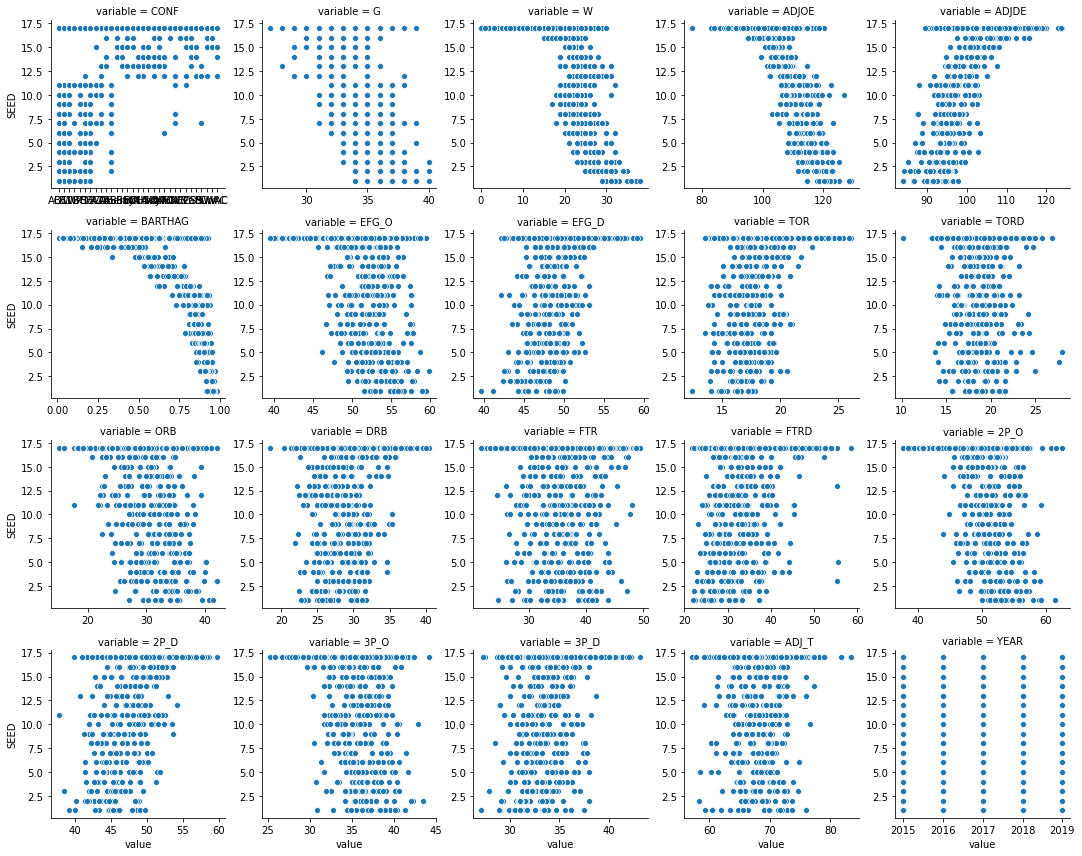

In [43]:
seed_con = sns.FacetGrid(cbb_seed_con_tall, col='variable', col_wrap=5, sharex=False, sharey=False )
seed_con.map(sns.scatterplot, 'value','SEED')

In [44]:
cbb_seed_con = cbb_seed_con.drop(columns=['CONF'])

In [45]:
from sklearn import linear_model

In [46]:
Y = cbb_seed_con['SEED']

X = cbb_seed_con.drop(columns=['SEED'])


lrm = linear_model.LinearRegression()

lrm.fit(X, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [47]:
predictions = lrm.predict(X)
errors = Y - predictions
# null hypothesis: data is homoscedastic
_, lmp, _, fp = het_breuschpagan(errors, X)

print(f"Reject Null: {lmp < 0.05}")
print(f"Reject Null: {fp < 0.05}")

Reject Null: True
Reject Null: True


In [48]:
y = cbb_seed_con['SEED']
X = cbb_seed_con.drop(columns=['SEED'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 85, stratify=y)

In [49]:
#played with dropping diff col to reduce multicoll

#print_vif(X_train.drop(columns=['2P_O', '2P_D', '3P_O', '3P_D', 'EFG_O', 'EFG_D','BARTHAG' ]))
#print_vif(X_train.drop(columns=['2P_O', '2P_D', '3P_O', '3P_D', 'EFG_O', 'EFG_D' ]))
#print_vif(X_train.drop(columns=['ADJOE', 'ADJDE','BARTHAG' ]))
#print_vif(X_train.drop(columns=['2P_O', '2P_D', '3P_O', '3P_D', 'EFG_O', 'EFG_D','ADJOE', 'ADJDE' ]))
#print_vif(X_train)

**MODELS NOT USED BUT TRYED**

In [50]:
y = cbb_seed_con['SEED']
X = cbb_seed_con.drop(columns=['SEED'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 85, stratify=y)

In [51]:
#ridge model
ridge = Ridge()

grid = {"alpha": [10, 100, 1000, 10000]}

ridge = GridSearchCV(Ridge(), grid, verbose=1, cv=5)
ridge.fit(X_train, y_train)

# The best fit is in the best_estimator_ attribute
print(f"selected alpha: {ridge.best_estimator_.alpha}")
display(ridge.best_estimator_.coef_)
display(ridge.best_params_)
display(ridge.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
selected alpha: 10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.0s finished


array([-1.07955414e-01, -2.41925337e-01, -4.77673406e-01,  2.23689955e-01,
        5.71680864e+00,  8.51816340e-01,  1.09913608e-01, -4.01509376e-01,
        8.39462797e-02,  1.26493551e-01, -1.15874182e-01,  7.13862643e-02,
       -9.59844833e-04, -2.40081873e-01, -1.54085021e-01, -2.34438697e-01,
       -1.23007282e-01,  1.98716842e-02,  1.69365470e-02])

{'alpha': 10}

0.533170550859781

In [52]:
y_pred_train = ridge.predict(X_train)
y_pred_test = ridge.predict(X_test)

In [53]:
ols_df = X_test.copy()
ols_df['predictions'] = y_pred_test
ols_df['actuals'] = y_test
ols_df.loc[(ols_df['actuals'] > 16), 'predictions'] = 17
ols_df['errors'] = ols_df['predictions'] -ols_df['actuals']
ols_df['abs_err'] = ols_df['errors'].abs()
ols_df['actual_label'] = ols_df['actuals'] <= 16
ols_df['pred_label'] = ols_df['predictions'] <= 16

In [54]:
cm = confusion_matrix(ols_df['actual_label'],ols_df['pred_label'])
cm_df = pd.DataFrame(
    cm, 
    index=['actual_0', 'actual_1'], 
    columns=['pred_0', 'pred_1']
)

display(cm_df)
print('\n')
print(classification_report(ols_df['actual_label'],ols_df['pred_label']))

,pred_0,pred_1
actual_0,269,0
actual_1,4,63




              precision    recall  f1-score   support

       False       0.99      1.00      0.99       269
        True       1.00      0.94      0.97        67

    accuracy                           0.99       336
   macro avg       0.99      0.97      0.98       336
weighted avg       0.99      0.99      0.99       336



In [55]:
#KNN REGRESSOR
pipeline = Pipeline(
    [
        ("feat_selection", SelectKBest(f_regression)),
        ("knn", KNeighborsRegressor()),
    ]
)


grid = {
    "feat_selection__k": range(2, 10),
    "knn__n_neighbors": range(2, 20),
    "knn__weights": ["uniform", "distance"],
}

pipeline_cv = GridSearchCV(pipeline, grid, verbose=1)
pipeline_cv.fit(X_train, y_train)

print("Best Params:")
print(pipeline_cv.best_params_)


Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best Params:
{'feat_selection__k': 6, 'knn__n_neighbors': 9, 'knn__weights': 'distance'}


[Parallel(n_jobs=1)]: Done 1440 out of 1440 | elapsed:   15.3s finished



train_score: 1.0
test_score: 0.8547500090083535
rmse 1.49
mae 0.67
mape 0.08


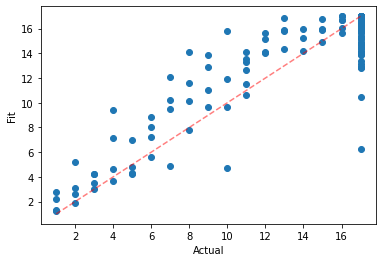

In [56]:
train_score = pipeline_cv.score(X_train, y_train)
test_score = pipeline_cv.score(X_test, y_test)

print(f"\ntrain_score: {train_score}")
print(f"test_score: {test_score}")

y_pred = pipeline_cv.predict(X_test)


eval_preds(y_test, y_pred)


In [57]:
#GradientBoostingRegressor
pipeline = Pipeline(
    [
        ("gbr", GradientBoostingRegressor())
    ]
)


grid = {
    
    "gbr__learning_rate": [.2, .3, .5]
}

pipeline_cv = GridSearchCV(pipeline, grid, verbose=1)
pipeline_cv.fit(X_train, y_train)

print("Best Params:")
print(pipeline_cv.best_params_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    5.9s finished


Best Params:
{'gbr__learning_rate': 0.2}



train_score: 0.974192902110335
test_score: 0.8123608781483446
rmse 1.69
mae 0.87
mape 0.11


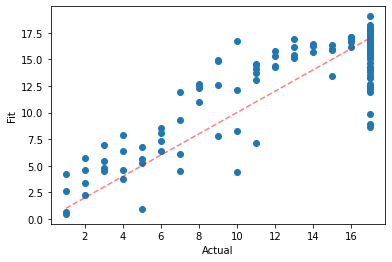

In [58]:
train_score = pipeline_cv.score(X_train, y_train)
test_score = pipeline_cv.score(X_test, y_test)

print(f"\ntrain_score: {train_score}")
print(f"test_score: {test_score}")

y_pred = pipeline_cv.predict(X_test)

eval_preds(y_test, y_pred)

In [59]:
#RandomForestClassifier
grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 50], 
    'min_samples_leaf': [1, 5, 25],
}

model = GridSearchCV(RandomForestClassifier(), grid, verbose=1, cv=2)
model.fit(X_train, y_train)

print(f'\nbest estimator from grid: {model.best_estimator_}')

print(f'\nbest params from grid: {model.best_params_}')

Fitting 2 folds for each of 27 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.



best estimator from grid: RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

best params from grid: {'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 50}


[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:   14.8s finished


In [60]:
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print(f'\ntrain_score: {train_score}')
print(f'test_score: {test_score}')


train_score: 0.8985831469052945
test_score: 0.8184523809523809


In [61]:
#KNN CLASS
grid = {'n_neighbors': list(range(15, 30))}
model = GridSearchCV(KNeighborsClassifier(), grid)
model.fit(X_train, y_train)

print(f'Best params: {model.best_params_}')


Best params: {'n_neighbors': 29}


In [62]:
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print(f'train_score: {train_score}')
print(f'test_score: {test_score}')

train_score: 0.8165548098434005
test_score: 0.8125


In [63]:
#SVC
grid= {
    'C': [ 1, 10, 100],
    'kernel': ['linear','poly','rbf'],
    'degree': [1, 2, 3]
}

model= GridSearchCV(SVC(), grid, verbose=1, cv=2)
model.fit(X_train,y_train)
model.best_params_

Fitting 2 folds for each of 27 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:    3.2s finished


{'C': 1, 'degree': 1, 'kernel': 'poly'}

In [64]:
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print(f'train_score: {train_score}')
print(f'test_score: {test_score}')

train_score: 0.8001491424310216
test_score: 0.8005952380952381
